# Covid-19 Death Prediction

We will estimate the number of patients who died due to Covid-19 using a time series.

Let's start the preparation phase.


In [ ]:
import pandas as pd #VERİ ANALİZİ İÇİN GEREKLİ KÜTÜPHANE
from fbprophet import Prophet #FACEBOOK META PROPHET OPEN SOURCE DAN YARARLANILDI.
from sklearn.metrics import mean_absolute_error #ORTALAMA HATA KÜTÜPHANESİ
import warnings; warnings.simplefilter('ignore') #UYARILARI GEÇERSİZ KILMA FİLTRE KÜTÜPHANESİ
import matplotlib.pyplot as plt #İSTATİSTİKSEL ÇİZİM İÇİN GEREKLİ KÜTÜPHANE


In [ ]:
from google.colab import drive #GOOGLE DRIVE İLE VERİ SETİNİ BAĞLAMAMIZ İÇİN GEREKLİ BLOK
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Set data...

In [ ]:
df = pd.read_csv('/content/drive/My Drive/MakineOgrenmesi/proje/corona.csv')
df.head()

,DAY,TESTS,POSITIVE,DEAD_TODAY,POSITIVE_RATIO,DEAD_POSITIVE_RATIO,DEAD_TOMORROW
0,14.1.2022,392438,67857,167,12,0,160
1,15.1.2022,410213,76542,174,14.201.183,0,170
2,16.1.2022,420058,7119,185,29,0,115
3,17.1.2022,425005,7186,108,255,19.607.843,125
4,18.1.2022,426542,7249,131,372,10.752.688,126


## Select required data...


In [ ]:
df= df[['DAY','DEAD_TODAY','DEAD_TOMORROW']].copy()
df.tail()

,DAY,DEAD_TODAY,DEAD_TOMORROW
44,27.2.2022,649,92
45,28.2.2022,725,89
46,1.3.2022,1456,93
47,2.3.2022,145,84
48,3.3.2022,246,114


## Data is virtualized on the Plot.


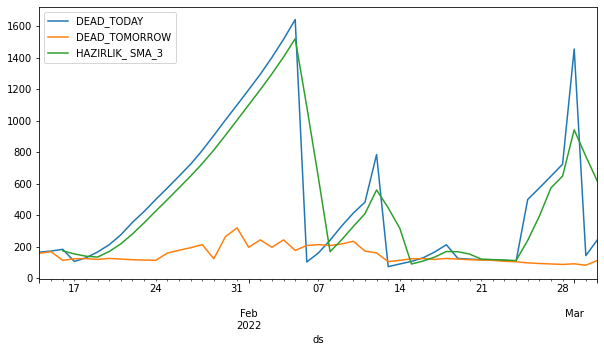

In [ ]:
df['ds'] = pd.to_datetime(df['DAY'],  dayfirst = True)
df.plot(x='ds',   figsize=(10, 5))


# METAVERSE FORECASTING METHOD (PROPHET)


We are testing our first trial estimation method on Probhet, which is a estimation method.

[Used Probhet Model.](https://facebook.github.io/prophet/docs/quick_start.html#python-api) 




## WE PREPARE THE DATA ACCORDING TO THE PROBHET MODEL.

In [ ]:
newdf = df[['ds', 'DEAD_TODAY']].copy()
df.drop(['ds'], axis=1, inplace=True)
newdf.rename(columns={'DEAD_TODAY': 'y'}, inplace=True)

newdf.tail()

,ds,y
44,2022-02-27,649
45,2022-02-28,725
46,2022-03-01,1456
47,2022-03-02,145
48,2022-03-03,246


## Running Prediction Algorithms


In [ ]:
m = Prophet( )
m.fit(newdf)
horizon= 1
future = m.make_future_dataframe(periods=horizon)
forecast = m.predict(future)
forecast[['ds',  'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
45,2022-02-28,372.728944,-207.770373,945.082424
46,2022-03-01,518.057877,-34.083824,1062.351397
47,2022-03-02,376.647308,-161.362321,947.140574
48,2022-03-03,439.758252,-159.910102,942.628799
49,2022-03-04,530.311829,-34.695999,1048.130764


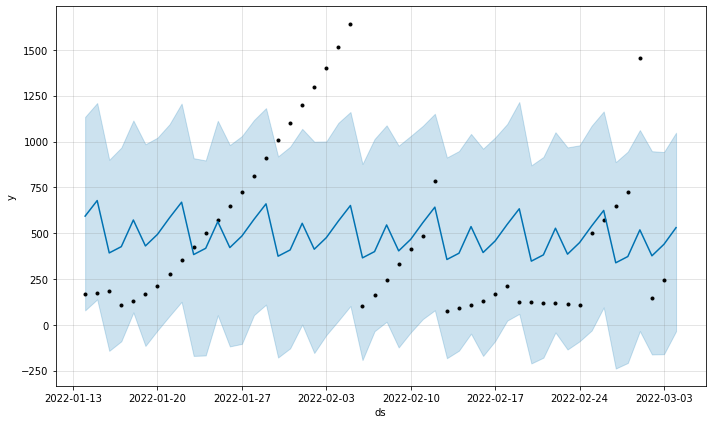

In [ ]:
fig1 = m.plot(forecast) #VERİYİ GÖRSELLEŞTİRİYORUZ.

## Estimated comparison with collected data


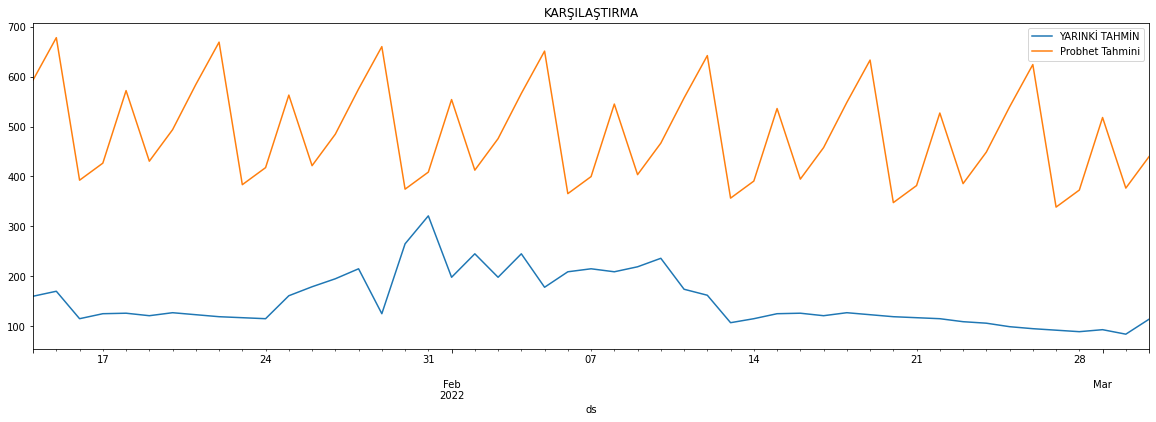

In [ ]:
comparison= pd.DataFrame()
comparison['ds']=newdf['ds'].copy()
comparison['YARINKİ TAHMİN']=df['DEAD_TOMORROW'].copy()
comparison['Probhet Tahmini'] = forecast[:-1].yhat
comparison.plot(title="KARŞILAŞTIRMA",x='ds',figsize=(20, 6))

#2. Forecasting Method: Simple Moving Average (SMA)

#Prediction


In [ ]:
window= 3
df['HAZIRLIK_ SMA_3'] = df.iloc[:,1].rolling(window=window).mean()
df.head()

,DAY,DEAD_TODAY,DEAD_TOMORROW,HAZIRLIK_ SMA_3
0,14.1.2022,167,160,NaN
1,15.1.2022,174,170,NaN
2,16.1.2022,185,115,175.333333
3,17.1.2022,108,125,155.666667
4,18.1.2022,131,126,141.333333


## Average Absolute Error


In [ ]:
MAE['SMA_3'] =  mean_absolute_error(df[2:-1]['DEAD_TOMORROW'], df[2:-1]['HAZIRLIK_ SMA_3'])
print("MAE (Ortalama Mutlak Hata) : {}".format(MAE))

MAE (Ortalama Mutlak Hata) : {'SMA_3': 348.71014492753625}


## Calculate standard deviation and upper-lower concentrations



<Figure size 1440x432 with 0 Axes>

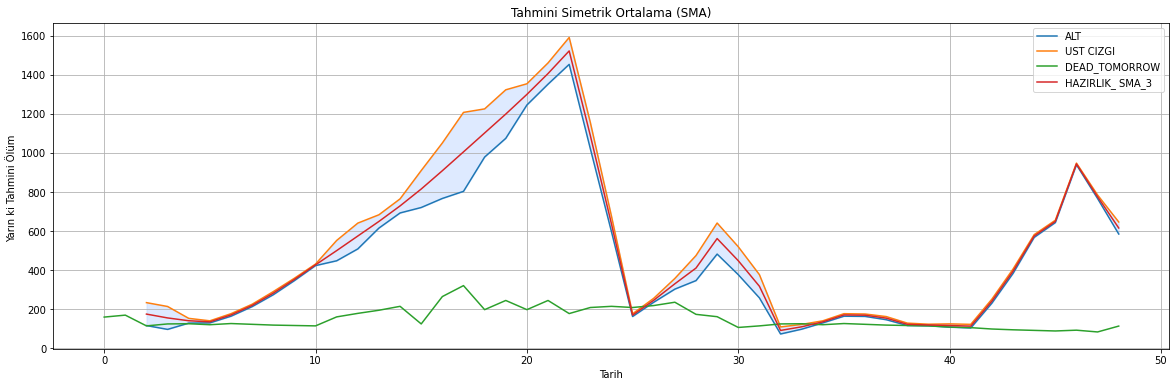

In [ ]:
rstd = df.iloc[:,2].rolling(window=window).std()
bands = pd.DataFrame()
bands['GÜN']= df['DAY'].copy()
bands['ALT'] = df['HAZIRLIK_ SMA_3'] - 2 * rstd
bands['UST CIZGI'] = df['HAZIRLIK_ SMA_3'] + 2 * rstd


bands = bands.join(df['DEAD_TOMORROW']).join(df['HAZIRLIK_ SMA_3'])
fig = plt.figure(figsize=(20, 6))
ax = bands.plot(title='Tahmini Simetrik Ortalama (SMA)', figsize=(20, 6))
ax.fill_between(bands.index, bands['ALT'], bands['UST CIZGI'], color='#ADCCFF', alpha=0.4)
ax.set_xlabel('Tarih')
ax.set_ylabel('Yarın ki Tahmini Ölüm ')
ax.grid()

plt.show()

## Estimated Comparison with Collected Data

           ds  YARINKİ TAHMİN  Probhet Tahmini  \
44 2022-02-27              92       338.572528   
45 2022-02-28              89       372.728944   
46 2022-03-01              93       518.057877   
47 2022-03-02              84       376.647308   
48 2022-03-03             114       439.758252   

    Tahmini Simetrik Ortalama (SMA)  
44                       574.666667  
45                       649.333333  
46                       943.333333  
47                       775.333333  
48                       615.666667  


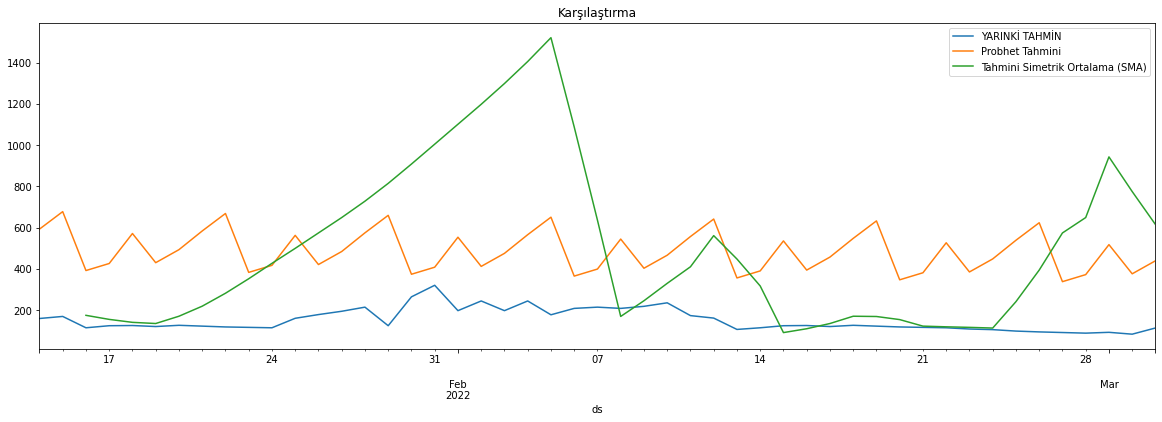

In [ ]:
comparison['Tahmini Simetrik Ortalama (SMA)'] = df['HAZIRLIK_ SMA_3']
print(comparison.tail())
comparison.plot(title="Karşılaştırma",x='ds',figsize=(20, 6))


#Graphical Summary(s) of General Operations

In [ ]:
print('Ortalama Mutlak Hata (MAE): {}'.format(MAE))

Ortalama Mutlak Hata (MAE): {'SMA_3': 348.71014492753625}


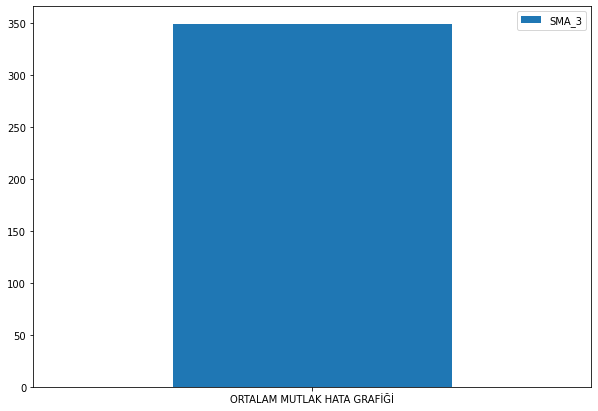

In [ ]:
errorsDF = pd.DataFrame(MAE, index=['ORTALAM MUTLAK HATA GRAFİĞİ']) 
ax = errorsDF.plot.bar(rot=0, figsize=(10, 7))

# My General Opinion / My Final Solution

Based on the content in the dataset we obtained from the Kaggle site;
* The number of data days in the data set we use is between 40-50.
* SMA and Probhet derivatives are suitable for low error rate.
* According to SMA (Simple Moving Average), it indicates that the next day's average number of deaths will hover around the 90 band.
* Based on our work in the data set, when we check the statistics in the relevant data group, the estimated number of deaths for the next day is highly accurate since it falls between the prediction line we named UST and the other line we named BOTTOM LINE.

In [ ]:
rstd.tail()

44     3.511885
45     3.000000
46     2.081666
47     4.509250
48    15.394804
Name: DEAD_TOMORROW, dtype: float64

In [ ]:
bands.tail()

,GÜN,ALT,UST CIZGI,DEAD_TOMORROW,HAZIRLIK_ SMA_3
44,27.2.2022,567.642897,581.690436,92,574.666667
45,28.2.2022,643.333333,655.333333,89,649.333333
46,1.3.2022,939.170001,947.496665,93,943.333333
47,2.3.2022,766.314834,784.351833,84,775.333333
48,3.3.2022,584.877058,646.456275,114,615.666667





**PREPARED BY**



GITHUB: https://github.com/meBerkay/ 
